<a href="https://colab.research.google.com/github/dolzhenkovmatvey/semantic_segmentation_pytorch/blob/main/proj_sem_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2021-11-15 08:46:15--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-11-15 08:46:15--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce543b4655726d49872e9c571b0.dl.dropboxusercontent.com/cd/0/inline/BaBRJRv7eNVYxOCusMZFlj64IyMXI2c2ImhtYcuSMjj_cLViHax37D_jcGTnwkiGVqS8UU1NqFq8PDESDDGvrBBPqtdjI_1G0bseDae5jKMuUZbqILLsvCRXA-_aXklX33QlEt1E7TBY0pLz2vmJm4ye/file# [following]
--2021-11-15 08:46:15--  https://uce543b4655726d49872e9c571b0.dl.dropboxusercontent.com/cd/0/inline/BaBRJRv7eNVYxOCusMZFlj64IyMXI2c2ImhtYcuSMjj_cLViHax37D_jcGTnwkiGVqS8UU1NqFq8PDESDDGv

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
print(len(images))

200


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

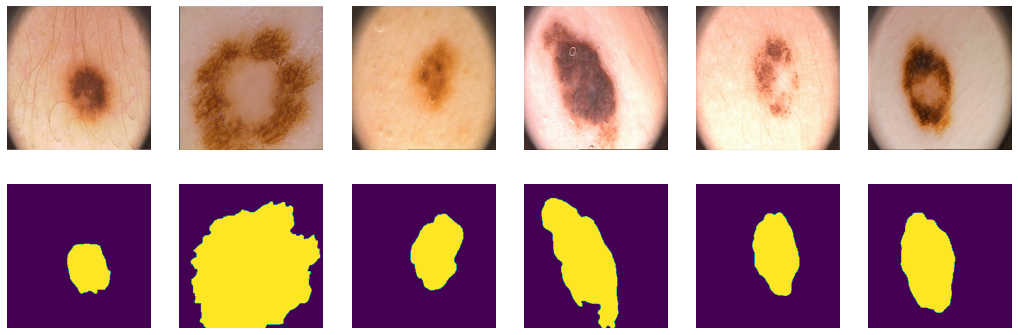

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


In [ ]:
!nvidia-smi

Mon Nov 15 08:46:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet [2 балла]

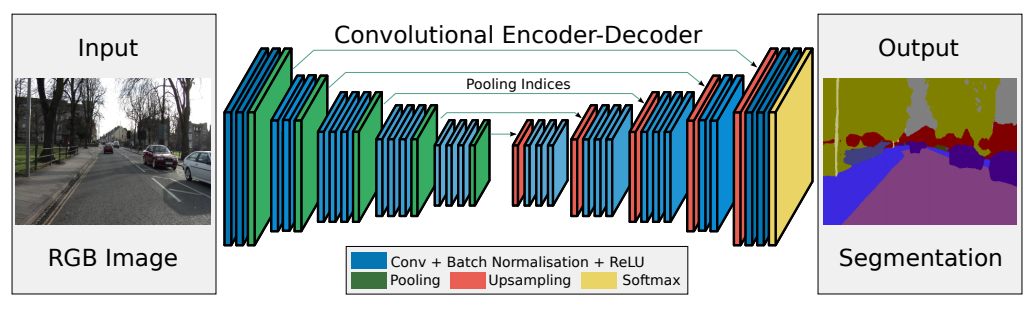

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)


In [ ]:
class SegNet(nn.Module):

	def __init__(self):
		super(SegNet, self).__init__()

		#SegNet Architecture
		#Takes input of size in_chn = 3 (RGB images have 3 channels)
		#Outputs size label_chn (N # of classes)

		#ENCODING consists of 5 stages
		#Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
		#Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

		#General Max Pool 2D for ENCODING layers
		#Pooling indices are stored for Upsampling in DECODING layers

		self.in_chn = 3

		self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

		self.ConvEn11 = nn.Conv2d(self.in_chn, 32, kernel_size=3, padding=1)
		self.BNEn11 = nn.BatchNorm2d(32)
		self.ConvEn12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
		self.BNEn12 = nn.BatchNorm2d(32)

		self.ConvEn21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.BNEn21 = nn.BatchNorm2d(64)
		self.ConvEn22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
		self.BNEn22 = nn.BatchNorm2d(64)

		self.ConvEn31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
		self.BNEn31 = nn.BatchNorm2d(128)
		self.ConvEn32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
		self.BNEn32 = nn.BatchNorm2d(128)
		self.ConvEn33 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
		self.BNEn33 = nn.BatchNorm2d(128)

		self.ConvEn41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
		self.BNEn41 = nn.BatchNorm2d(256)
		self.ConvEn42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNEn42 = nn.BatchNorm2d(256)
		self.ConvEn43 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNEn43 = nn.BatchNorm2d(256)

		self.ConvEn51 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNEn51 = nn.BatchNorm2d(256)
		self.ConvEn52 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNEn52 = nn.BatchNorm2d(256)
		self.ConvEn53 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNEn53 = nn.BatchNorm2d(256)


		#DECODING consists of 5 stages
		#Each stage corresponds to their respective counterparts in ENCODING

		#General Max Pool 2D/Upsampling for DECODING layers
		self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

		self.ConvDe53 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNDe53 = nn.BatchNorm2d(256)
		self.ConvDe52 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNDe52 = nn.BatchNorm2d(256)
		self.ConvDe51 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNDe51 = nn.BatchNorm2d(256)

		self.ConvDe43 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNDe43 = nn.BatchNorm2d(256)
		self.ConvDe42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
		self.BNDe42 = nn.BatchNorm2d(256)
		self.ConvDe41 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
		self.BNDe41 = nn.BatchNorm2d(128)

		self.ConvDe33 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
		self.BNDe33 = nn.BatchNorm2d(128)
		self.ConvDe32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
		self.BNDe32 = nn.BatchNorm2d(128)
		self.ConvDe31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
		self.BNDe31 = nn.BatchNorm2d(64)

		self.ConvDe22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
		self.BNDe22 = nn.BatchNorm2d(64)
		self.ConvDe21 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
		self.BNDe21 = nn.BatchNorm2d(32)

		self.ConvDe12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
		self.BNDe12 = nn.BatchNorm2d(32)
		self.ConvDe11 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
		self.BNDe11 = nn.BatchNorm2d(1)

	def forward(self, x):

		#ENCODE LAYERS
		#Stage 1
		x = F.relu(self.BNEn11(self.ConvEn11(x))) 
		x = F.relu(self.BNEn12(self.ConvEn12(x))) 
		x, ind1 = self.MaxEn(x)
		size1 = x.size()

		#Stage 2
		x = F.relu(self.BNEn21(self.ConvEn21(x))) 
		x = F.relu(self.BNEn22(self.ConvEn22(x))) 
		x, ind2 = self.MaxEn(x)
		size2 = x.size()

		#Stage 3
		x = F.relu(self.BNEn31(self.ConvEn31(x))) 
		x = F.relu(self.BNEn32(self.ConvEn32(x))) 
		x = F.relu(self.BNEn33(self.ConvEn33(x))) 	
		x, ind3 = self.MaxEn(x)
		size3 = x.size()

		#Stage 4
		x = F.relu(self.BNEn41(self.ConvEn41(x))) 
		x = F.relu(self.BNEn42(self.ConvEn42(x))) 
		x = F.relu(self.BNEn43(self.ConvEn43(x))) 	
		x, ind4 = self.MaxEn(x)
		size4 = x.size()

		#Stage 5
		x = F.relu(self.BNEn51(self.ConvEn51(x))) 
		x = F.relu(self.BNEn52(self.ConvEn52(x))) 
		x = F.relu(self.BNEn53(self.ConvEn53(x))) 	
		x, ind5 = self.MaxEn(x)
		size5 = x.size()

		#DECODE LAYERS
		#Stage 5
		x = self.MaxDe(x, ind5, output_size=size4)
		x = F.relu(self.BNDe53(self.ConvDe53(x)))
		x = F.relu(self.BNDe52(self.ConvDe52(x)))
		x = F.relu(self.BNDe51(self.ConvDe51(x)))

		#Stage 4
		x = self.MaxDe(x, ind4, output_size=size3)
		x = F.relu(self.BNDe43(self.ConvDe43(x)))
		x = F.relu(self.BNDe42(self.ConvDe42(x)))
		x = F.relu(self.BNDe41(self.ConvDe41(x)))

		#Stage 3
		x = self.MaxDe(x, ind3, output_size=size2)
		x = F.relu(self.BNDe33(self.ConvDe33(x)))
		x = F.relu(self.BNDe32(self.ConvDe32(x)))
		x = F.relu(self.BNDe31(self.ConvDe31(x)))

		#Stage 2
		x = self.MaxDe(x, ind2, output_size=size1)
		x = F.relu(self.BNDe22(self.ConvDe22(x)))
		x = F.relu(self.BNDe21(self.ConvDe21(x)))

		#Stage 1
		x = self.MaxDe(x, ind1)
		x = F.relu(self.BNDe12(self.ConvDe12(x)))
		x = self.ConvDe11(x)

		return x

**IOU**


In [ ]:
def my_iou(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))        
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    
    return iou

**Bce_loss**

In [ ]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

In [ ]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    update_val_data = epochs/2
    train_losses = []
    val_losses = []
    iou_score = []
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        if (epoch == update_val_data):
          X_val, Y_val = next(iter(data_val))
        Y_hat = model(X_val.to(device)).detach().to('cpu')  # detach and put into cpu
        val_losses.append(loss_fn(Y_val, Y_hat))
        iou_score.append(score_model(model, my_iou, data_val))
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        scheduler.step()
    return train_losses, val_losses, iou_score

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
      with torch.no_grad():
        Y_pred = model(X_batch.to(device))
      Y_pred = Y_pred > 0.5
      scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
model = SegNet().to(device)

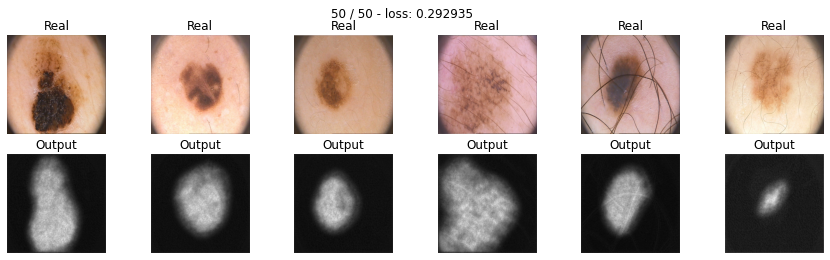

In [ ]:
max_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)
bce_train_loss, bce_val_loss, bce_iou = train(model, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
seg_bce_score = score_model(model, my_iou, data_ts)

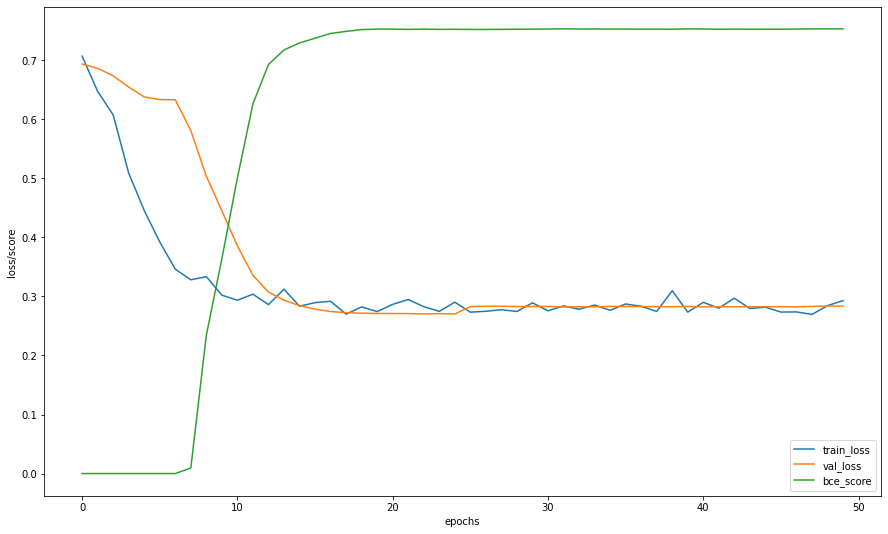

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(bce_train_loss, label="train_loss")
plt.plot(bce_val_loss, label="val_loss")
plt.plot(bce_iou, label="bce_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/score")
plt.show()

**Dice_loss**

In [ ]:
def dice_loss(y_real, y_pred, eps = 1e-6):
    num = torch.sum(torch.sum(torch.sum(y_pred * y_real, 3), 2), 1)
    den1 = torch.sum(torch.sum(torch.sum(y_pred * y_pred, 3), 2), 1)
    den2 = torch.sum(torch.sum(torch.sum(y_real * y_real, 3), 2), 1)
    dice_coef = 2 * ((num + eps) / (den1 + den2 + eps))
    loss = 1 - torch.mean(dice_coef)
    return loss

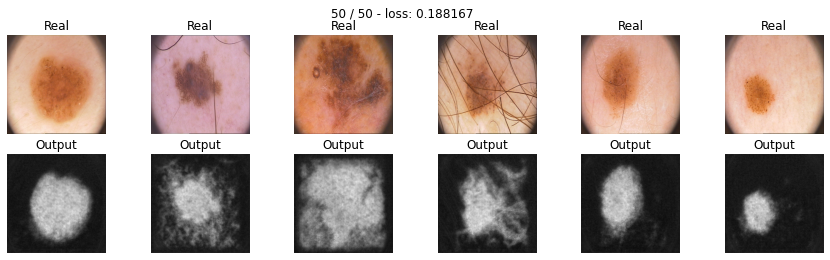

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 50
optimizer = torch.optim.Adam(model_dice.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)
dice_train_loss, dice_val_loss, dice_iou = train(model_dice, optimizer, scheduler, dice_loss, max_epochs, data_tr, data_val)

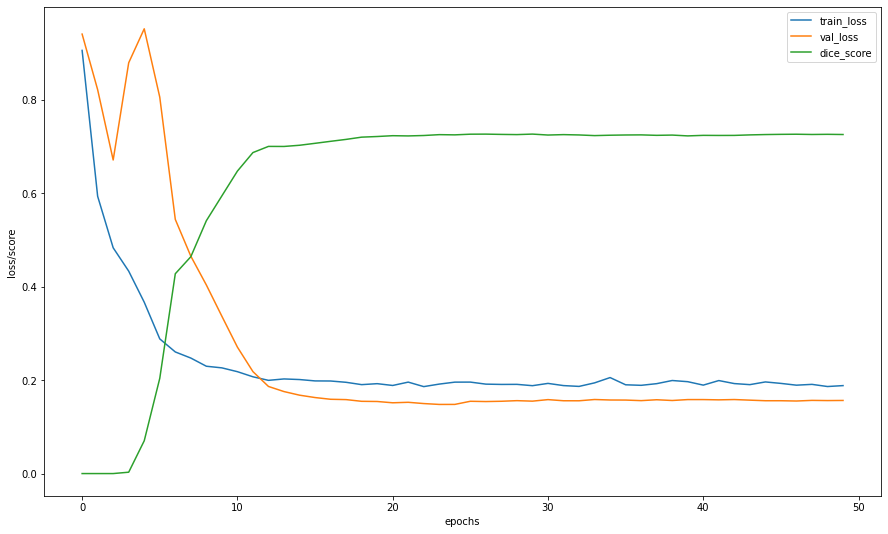

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(dice_train_loss, label="train_loss")
plt.plot(dice_val_loss, label="val_loss")
plt.plot(dice_iou, label="dice_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/score")
plt.show()

In [ ]:
seg_dice_score = score_model(model_dice, my_iou, data_ts)

**Focal_loss**

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    probs = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    return -torch.mean(((1 - probs) ** gamma) * y_real * torch.log(probs) + (1 - y_real) * torch.log(1 - probs))


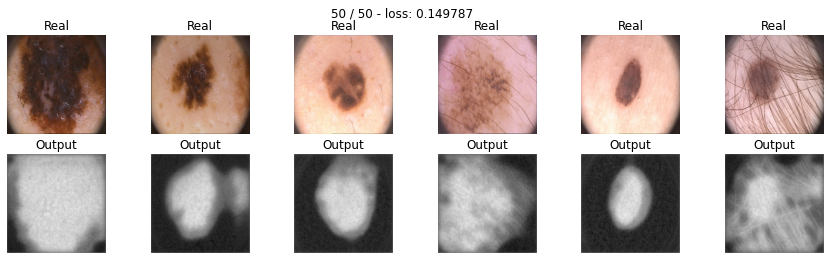

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 50
optimizer = torch.optim.Adam(model_focal.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)
focal_train_loss, focal_val_loss, focal_iou = train(model_focal, optimizer, scheduler, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
seg_focal_score = score_model(model_focal, my_iou, data_ts)

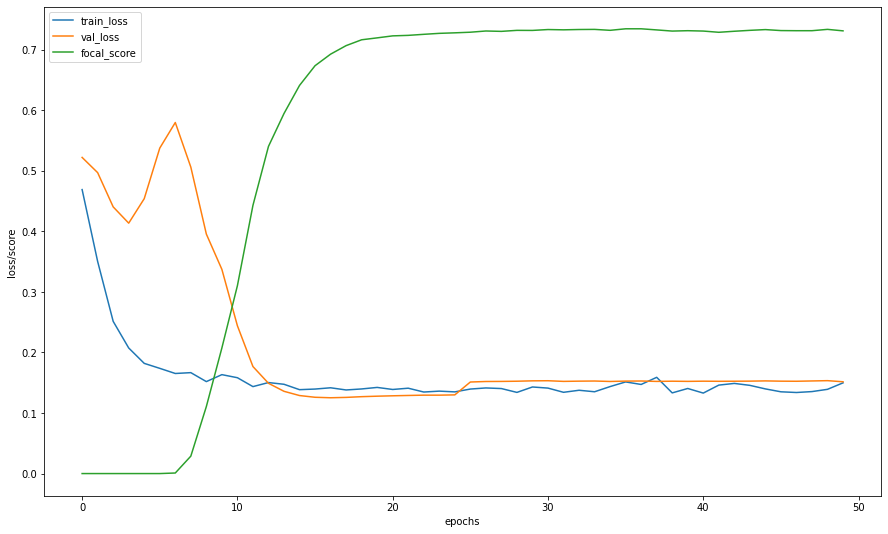

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(focal_train_loss, label="train_loss")
plt.plot(focal_val_loss, label="val_loss")
plt.plot(focal_iou, label="focal_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/score")
plt.show()

**Unet**

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                                       nn.Conv2d(3,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,32,3, padding = 1),                                      
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                                       nn.Conv2d(32,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),                                      
                                       )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                                       nn.Conv2d(64,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),  
                                       nn.Conv2d(128,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),  
                                       )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                                       nn.Conv2d(128,256,3, padding = 1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),  
                                       nn.Conv2d(256,256,3, padding = 1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),  
                                       )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                              nn.Conv2d(256, 512, 3, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU(),
                                              nn.Conv2d(512, 512, 3, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU()
                                              )

        # decoder (upsampling)
        self.upconv4 = nn.ConvTranspose2d(512,256,2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                       nn.Conv2d(512,256,3, padding = 1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),  
                                       nn.Conv2d(256,256,3, padding = 1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU()
                                       )
        self.upconv3 = nn.ConvTranspose2d(256,128,2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                                       nn.Conv2d(256,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),  
                                       nn.Conv2d(128,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU()
                                       )
        self.upconv2 = nn.ConvTranspose2d(128,64,2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                       nn.Conv2d(128,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),  
                                       nn.Conv2d(64,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU()
                                       )
        self.upconv1 = nn.ConvTranspose2d(64,32,2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                       nn.Conv2d(64,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),  
                                       nn.Conv2d(32,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,1,3, padding = 1)
                                       )

    def forward(self, x): 
        e00 = self.enc_conv0(x)
        e0, indices0 = self.pool0(e00)
        e10 = self.enc_conv1(e0)
        e1, indices1 = self.pool1(e10)
        e20 = self.enc_conv2(e1)
        e2, indices2 = self.pool2(e20)
        e30 = self.enc_conv3(e2)
        e3, indices3 = self.pool3(e30)
        # bottleneck
        x = self.bottleneck_conv(e3)
        # decoder
        x = self.dec_conv0(torch.cat([self.upconv4(x),e30], dim = 1))
        x = self.dec_conv1(torch.cat([self.upconv3(x),e20], dim = 1))
        x = self.dec_conv2(torch.cat([self.upconv2(x),e10], dim = 1))
        x = self.dec_conv3(torch.cat([self.upconv1(x),e00], dim = 1))  # no activation
        return x

Unet with bce_loss

In [ ]:
unet_model_bce = UNet().to(device)

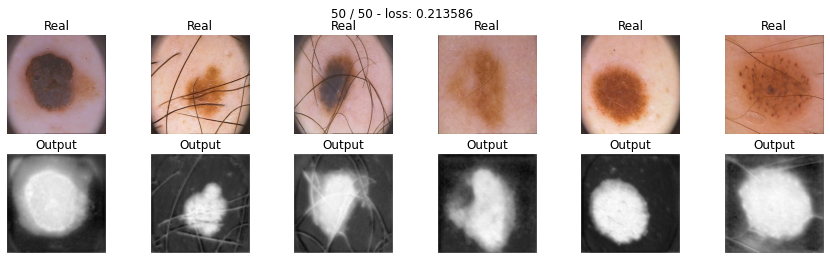

In [ ]:
max_epochs = 50
optimizer = torch.optim.Adam(unet_model_bce.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)
unet_bce_train_loss, unet_bce_val_loss, unet_bce_iou = train(unet_model_bce, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

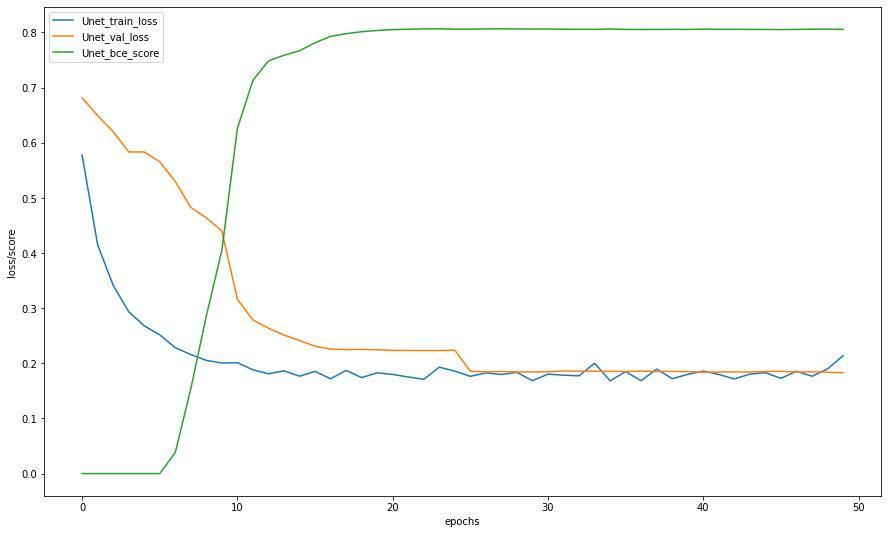

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(unet_bce_train_loss, label="Unet_train_loss")
plt.plot(unet_bce_val_loss, label="Unet_val_loss")
plt.plot(unet_bce_iou, label="Unet_bce_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/score")
plt.show()

In [ ]:
unet_bce_score = score_model(unet_model_bce, my_iou, data_ts)

Unet with focal_loss

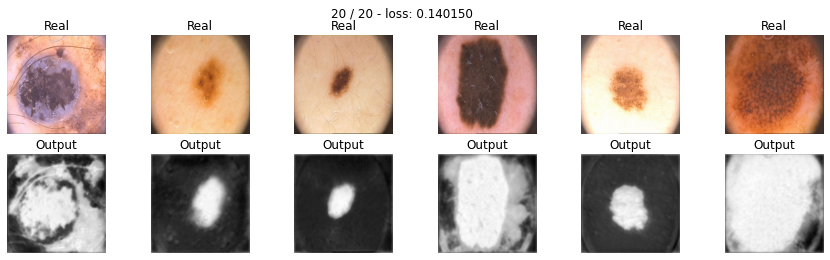

In [ ]:
unet_model_focal = UNet().to(device)
max_epochs = 20
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)
unet_focal_train_loss, unet_focal_val_loss, unet_focal_iou = train(unet_model_focal, optimizer, scheduler, focal_loss, max_epochs, data_tr, data_val)

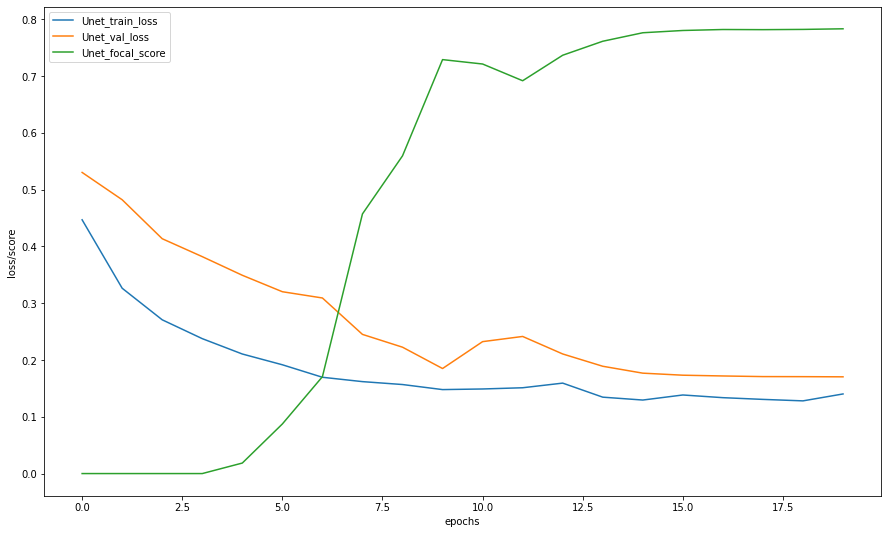

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(unet_focal_train_loss, label="Unet_train_loss")
plt.plot(unet_focal_val_loss, label="Unet_val_loss")
plt.plot(unet_focal_iou, label="Unet_focal_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/score")
plt.show()

In [ ]:
unet_focal_score = score_model(unet_model_focal, my_iou, data_ts)

In [ ]:
unet_focal_score

0.770188182592392

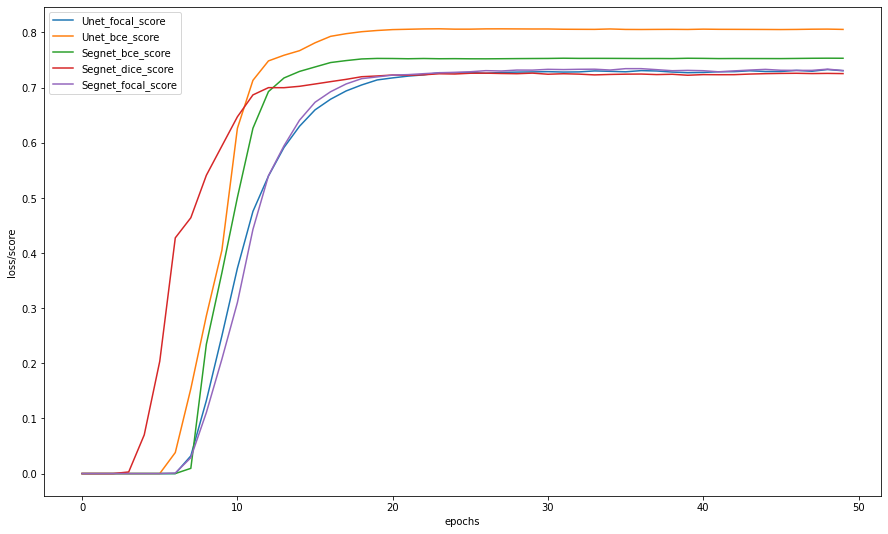

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(unet_focal_iou, label="Unet_focal_score")
plt.plot(unet_bce_iou, label="Unet_bce_score")
plt.plot(bce_iou, label="Segnet_bce_score")
plt.plot(dice_iou, label="Segnet_dice_score")
plt.plot(focal_iou, label="Segnet_focal_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss/score")
plt.show()